<a href="https://colab.research.google.com/github/ZHBIT92/deep_learn/blob/master/%E7%8C%AB%E7%8B%97%E5%9B%BEV3%E5%BE%AE%E8%B0%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

# 下载Inception V3的权重
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

* 通过指定include_top=False参数，我们加载一个网络，该网络不包括最适合特征提取的分类层。

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

# 让预训练模型不可训练，权重不变（只用于特征提取）
for layer in pre_trained_model.layers:
  layer.trainable = False

# 截取到V3中的mixed7层（7*7）特征
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output  

last layer output shape: (None, 7, 7, 768)


In [0]:
from tensorflow.keras.optimizers import RMSprop

# 展平为一维
x = layers.Flatten()(last_output)
# 添加一个1024个隐藏单元的全连接层
x = layers.Dense(1024, activation='relu')(x)
# 0.2丢弃
x = layers.Dropout(0.2)(x)
# sigmoid分类
x = layers.Dense(1, activation='sigmoid')(x)

# 编辑模型
model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.0001),
              metrics=['acc'])

In [6]:
!wget --no-check-certificate \
   https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

# 数据处理
  
import os
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# 数据增强（随机转换）
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# 训练集不变
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir, # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

--2018-10-24 02:47:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  88.8MB/s    in 0.7s    

2018-10-24 02:47:45 (88.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=2,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/2
 - 204s - loss: 0.3300 - acc: 0.8540 - val_loss: 0.2865 - val_acc: 0.9350
Epoch 2/2
 - 200s - loss: 0.3066 - acc: 0.8705 - val_loss: 0.3253 - val_acc: 0.9410


In [9]:
from tensorflow.keras.optimizers import SGD

# 锁定层不可变
unfreeze = False

# 解锁mixed6后面的层
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# As an optimizer, here we will use SGD
# SGD优化器
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  lr=0.00001, 
                  momentum=0.9),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 222s - loss: 0.2824 - acc: 0.8810 - val_loss: 0.3328 - val_acc: 0.9420
Epoch 2/30
 - 219s - loss: 0.2831 - acc: 0.8805 - val_loss: 0.3286 - val_acc: 0.9430
Epoch 3/30
 - 220s - loss: 0.2459 - acc: 0.8975 - val_loss: 0.3272 - val_acc: 0.9460
Epoch 4/30
 - 220s - loss: 0.2681 - acc: 0.8835 - val_loss: 0.3261 - val_acc: 0.9450
Epoch 5/30
 - 220s - loss: 0.2685 - acc: 0.8900 - val_loss: 0.3293 - val_acc: 0.9460
Epoch 6/30
 - 220s - loss: 0.2747 - acc: 0.8850 - val_loss: 0.3311 - val_acc: 0.9450
Epoch 7/30
 - 219s - loss: 0.2714 - acc: 0.8840 - val_loss: 0.3316 - val_acc: 0.9450
Epoch 8/30
 - 219s - loss: 0.2546 - acc: 0.8890 - val_loss: 0.3292 - val_acc: 0.9450
Epoch 9/30
 - 221s - loss: 0.2579 - acc: 0.8855 - val_loss: 0.3286 - val_acc: 0.9440
Epoch 10/30
 - 221s - loss: 0.2624 - acc: 0.8795 - val_loss: 0.3392 - val_acc: 0.9420
Epoch 11/30
 - 221s - loss: 0.2648 - acc: 0.8760 - val_loss: 0.3389 - val_acc: 0.9420
Epoch 12/30
 - 221s - loss: 0.2693 - acc: 0.8890 - val_loss: 0.

Text(0.5,1,'Training and validation loss')

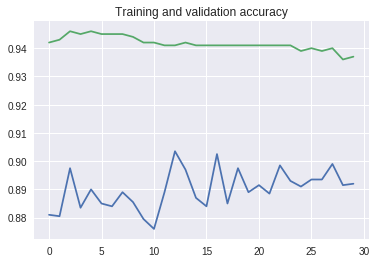

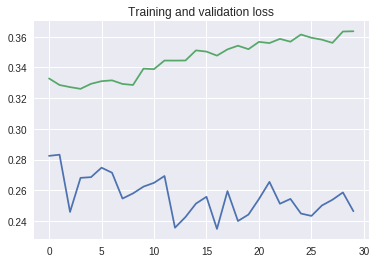

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')